<a href="https://colab.research.google.com/github/yahyahabib65/AI-623/blob/main/AI_623_PA0_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

## 1.1. Baseline Setup

In [1]:
# Import Libraries
import torchvision
import torch
from torchvision.models import resnet152
import torchvision.datasets as ds


# (a) Use a pre-trained ResNet-152 from PyTorch.
model = resnet152(pretrained=True)

# (b) Replace the final classification layer to match a smaller dataset such as CIFAR-10.
#TODO Replace fc with Smaller Dataset i.e CIFAR-10
# Getting CIFAR10 Classes
num_classes = ds.CIFAR10(root='./data', train=True, download=True).classes
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, len(num_classes))

# (c) Train only the classification head while freezing the rest of the backbone.
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreezes the classification head
for param in model.fc.parameters():
    param.requires_grad = True




/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:02<00:00, 106MB/s] 
100%|██████████| 170M/170M [00:18<00:00, 9.20MB/s]


In [2]:
# (d) Record training and validation performance for a few epochs. say 4 epochs
# Training and Testing validation
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Data
transform = T.Compose([T.Resize(224), T.ToTensor()])
trainset = ds.CIFAR10(root='./data', train=True, transform=transform, download=True)
testset  = ds.CIFAR10(root='./data', train=False, transform=transform, download=True)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

epochs = 4
for epoch in range(epochs):
    # ---- Training ----
    model.train()
    train_loss, correct = 0, 0
    print(f"Number of Samples: {len(trainset)} in epoch {epoch}")
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    train_acc = correct / len(trainset)

    # ---- Validation ----
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

    val_acc = correct / len(testset)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.3f}, Train Acc={train_acc:.3f}, "
          f"Val Loss={val_loss:.3f}, Val Acc={val_acc:.3f}")


Number of Samples: 50000 in epoch 0
Epoch 1: Train Loss=525.298, Train Acc=0.780, Val Loss=82.320, Val Acc=0.813
Number of Samples: 50000 in epoch 1
Epoch 2: Train Loss=398.554, Train Acc=0.824, Val Loss=77.851, Val Acc=0.827
Number of Samples: 50000 in epoch 2
Epoch 3: Train Loss=375.836, Train Acc=0.834, Val Loss=72.852, Val Acc=0.842
Number of Samples: 50000 in epoch 3
Epoch 4: Train Loss=366.726, Train Acc=0.837, Val Loss=74.543, Val Acc=0.836


- CIFAR10 has 50K training Images and 10K Testing Images
- ResNet Model has 60 Million Parameters
- Data is highly Prone to Overfitting

### It is observed in model regarding transferability that model performs fairly well which is due to the fact that:
- Prior Layers before final classification layer Learn Generic Features such as Shapes Textures contrast and edges
- And these features are reusable accross datasets
- Thus Proving that Resnet is Overkill for small Dataset like CIFAR10

## 1.2  Residual Connections in Practice

Epoch 1: Train Acc=0.650, Val Acc=0.697
Epoch 2: Train Acc=0.699, Val Acc=0.711
Epoch 3: Train Acc=0.709, Val Acc=0.711
Epoch 4: Train Acc=0.715, Val Acc=0.711


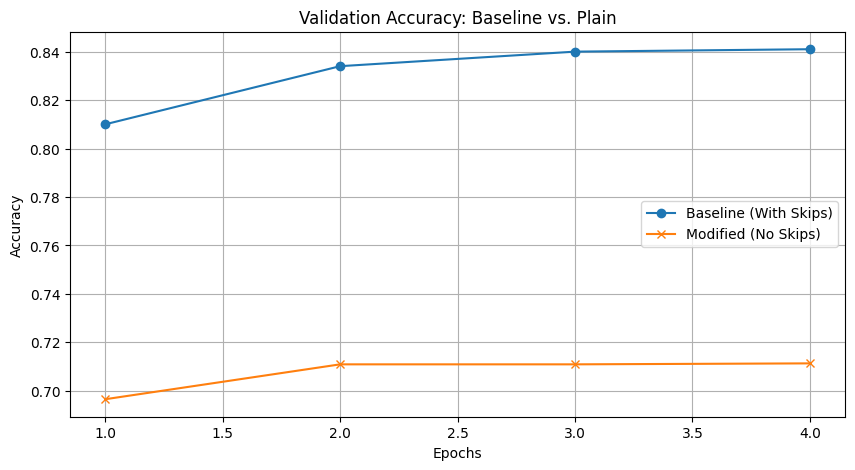

In [3]:
import types
import torch
import torch.optim as optim
import torchvision
from torchvision.models import resnet152, ResNet152_Weights


def forward_plain(self, x):
    identity = x
    #layer by layer computation
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    # Disable the skip connection (Residual addition)
    # out += identity  Disabled

    out = self.relu(out)
    return out

# 2. Setup the Plain Model
plain_model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)

# Match the baseline: replace the final classification layer for CIFAR-10
in_features = plain_model.fc.in_features
plain_model.fc = torch.nn.Linear(in_features, 10)

# Monkey-patch: Replace forward method in layer 4 blocks
for block in plain_model.layer4:
    block.forward = types.MethodType(forward_plain, block)

# 3. Training Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
plain_model.to(device)

# Freeze backbone, train only the classification head [cite: 17]
for param in plain_model.parameters():
    param.requires_grad = False
for param in plain_model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(plain_model.fc.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()





#baseline stup history
plain_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
epochs = 4

for epoch in range(epochs):
    # ---- Training ----
    plain_model.train()
    train_loss, correct, total = 0, 0, 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = plain_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = correct / total

    # ---- Validation ----
    plain_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            out = plain_model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total

    # Store history for comparison
    plain_history['train_loss'].append(train_loss / len(trainloader))
    plain_history['train_acc'].append(train_acc)
    plain_history['val_loss'].append(val_loss / len(testloader))
    plain_history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")


import matplotlib.pyplot as plt

# baseline accuracy values
baseline_val_acc = [0.810, 0.834, 0.840, 0.841]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 5), baseline_val_acc, label='Baseline (With Skips)', marker='o')
plt.plot(range(1, 5), plain_history['val_acc'], label='Modified (No Skips)', marker='x')
plt.title('Validation Accuracy: Baseline vs. Plain')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 1.3

In [4]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dictionary to store features
features = {}

def get_features(name):
    def hook(model, input, output):
        # Flatten the spatial dimensions (B, C, H, W) -> (B, C*H*W) or use Global Average Pooling
        features[name] = torch.mean(output, dim=[2, 3]).detach().cpu().numpy()
    return hook

# Register hooks for early, middle, and late layers
hooks = [
    model.layer1.register_forward_hook(get_features('early')),
    model.layer3.register_forward_hook(get_features('middle')),
    model.layer4.register_forward_hook(get_features('late'))
]

# Run a batch of test data through the model
model.eval()
data_iter = iter(testloader)
images, labels = next(data_iter)
images = images.to(device)

with torch.no_grad():
    _ = model(images)

# Remove hooks after use
for h in hooks:
    h.remove()

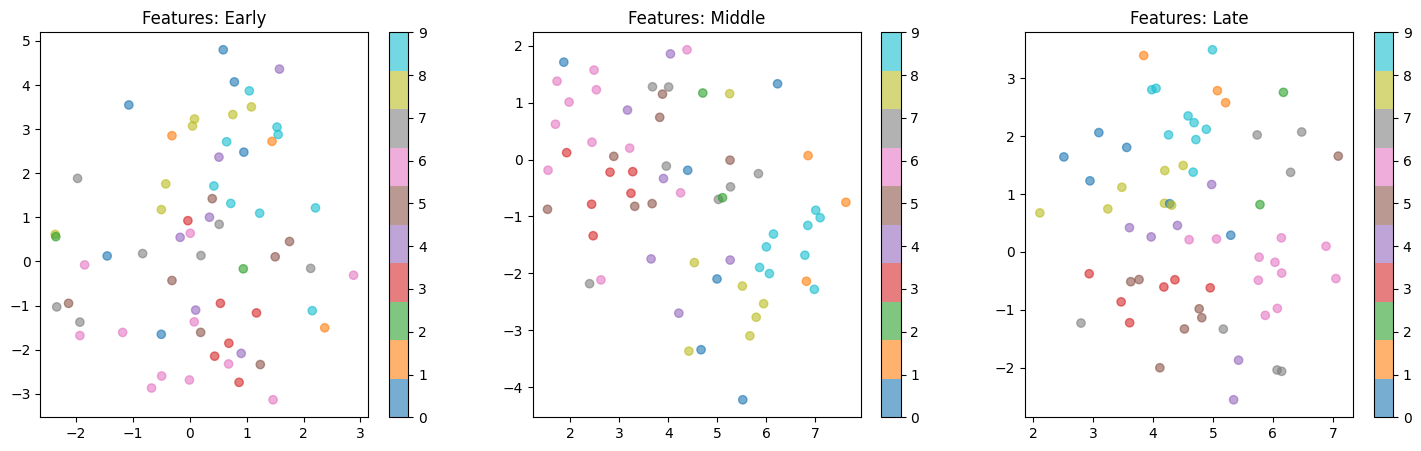

In [5]:
def plot_tsne(feature_set, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(feature_set)

    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.title(title)
    plt.colorbar()

plt.figure(figsize=(18, 5))
for i, layer in enumerate(['early', 'middle', 'late']):
    plt.subplot(1, 3, i+1)
    plot_tsne(features[layer], labels.numpy(), f'Features: {layer.capitalize()}')
plt.show()

## 1.4

In [ ]:
import torch
import torch.optim as optim
import torchvision
from torchvision.models import resnet152, ResNet152_Weights
import matplotlib.pyplot as plt

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 4  # Keep consistent with baseline

def get_model(init_type='pretrained', tune_mode='head_only'):
    """
    Args:
        init_type: 'pretrained' or 'random'
        tune_mode: 'head_only', 'full', or 'layer4' (final block)
    """
    # 1. Initialize Weights
    if init_type == 'pretrained':
        weights = ResNet152_Weights.IMAGENET1K_V1
    else:
        weights = None  # Random initialization

    model = resnet152(weights=weights)

    # 2. Modify Head for CIFAR-10
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model.to(device)

    # 3. Freeze/Unfreeze Layers based on Strategy
    if tune_mode == 'full' or init_type == 'random':
        # Train everything (Random init MUST train everything)
        for param in model.parameters():
            param.requires_grad = True

    elif tune_mode == 'head_only':
        # Freeze everything first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze head
        for param in model.fc.parameters():
            param.requires_grad = True

    elif tune_mode == 'layer4':
        # Freeze everything first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze Layer 4 (Final Block) and Head
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    return model

def train_and_log(model, name):
    print(f"Starting Training: {name}")
    criterion = torch.nn.CrossEntropyLoss()
    # Use smaller LR for full fine-tuning to prevent destroying pretrained features
    lr = 1e-4 if 'Full' in name else 1e-3 # condition to use smaller lr if dataset is full
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    acc_history = []

    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0

        for x, y in trainloader: # Uses loader from Task 1.1
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        epoch_acc = correct / total
        acc_history.append(epoch_acc)
        print(f"  Epoch {epoch+1}: Acc = {epoch_acc:.3f}")

    return acc_history

# ---- RUN EXPERIMENTS ----

# 1. Random Initialization (Train from Scratch)
model_random = get_model(init_type='random', tune_mode='full')
hist_random = train_and_log(model_random, "Random Init (Scratch)")

# 2. Fine-tune Final Block (Layer 4 + Head)
model_layer4 = get_model(init_type='pretrained', tune_mode='layer4')
hist_layer4 = train_and_log(model_layer4, "Fine-tune Final Block")

# 3. Fine-tune Full Backbone
model_full = get_model(init_type='pretrained', tune_mode='full')
hist_full = train_and_log(model_full, "Fine-tune Full Backbone")

# Plot Comparisons
plt.figure(figsize=(10, 6))
# Add your Baseline (Head Only) data from Task 1.1 manually if needed, e.g., [0.78, 0.82...]
plt.plot(hist_random, label='Random Init (Scratch)', marker='s')
plt.plot(hist_layer4, label='Fine-tune Final Block', marker='^')
plt.plot(hist_full, label='Fine-tune Full Backbone', marker='o')
plt.title('Transfer Learning Strategies: Convergence Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Starting Training: Random Init (Scratch)


## 1.5

In [ ]:
!pip install umap-learn

In [ ]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X = features['late']
y = labels.numpy()

# 2. Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# 3. Run UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(16, 7))

# Plot t-SNE
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
plt.title('t-SNE: Local Structure Focus')
plt.colorbar()

# Plot UMAP
plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
plt.title('UMAP: Global Structure Focus')
plt.colorbar()

plt.show()